<a href="https://colab.research.google.com/github/xtrimkeyz/gozpel/blob/master/FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MALWARE DETECTION
**Aim:**

To develop a Machine Learning-based framework for malware detection using artificial neural network (ANN) algorithm.
Test and evaluate the results to determine the effectiveness and efficiencies of the machine learning-based algorithms in (1) above

### DATA:




IMPORTATION OF LIBRARIES

In [ ]:
# Common import for basic EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# other imports
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Basic EDA and Feature Selection

In [ ]:
# load the dataset
df = pd.read_csv('drive/My Drive/Dog vision/Kaggle-data.csv')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate,Unnamed: 57
0,1,b69acb3bb133974e48229627663f96d4,332,224,8450,8.0,0,16896,8192,0,16947,4096,24576,4194304.0,4096,512,6,0,6,0,5,1,40960,1024,84427,2,320,262144,4096,1048576,4096,0,16,4,3.761598,2.446533,6.450720,6016.000000,1024,16896,6096.250000,960.0,16731,3,44,0,31,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1,NaN
1,2,1cbee4b3725629bd0aa6ac2ff500925f,332,224,258,9.0,0,84480,25600,0,10973,4096,90112,65536.0,4096,512,5,0,9,0,4,20,126976,1024,180181,9,320,65536,4096,1048576,4096,0,16,5,4.973822,3.269968,6.504334,22016.000000,1024,84480,21902.800000,992.0,84410,2,102,100,2,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1,NaN
2,3,b7027cf0cd31c820928950cbfe7e91ef,332,224,8450,8.0,0,4608,3584,0,6452,4096,12288,264962048.0,4096,512,6,0,6,0,6,0,24576,1024,10208,2,320,262144,4096,1048576,4096,0,16,4,3.329824,0.278747,6.051986,1792.000000,512,4608,1708.000000,414.0,4294,2,27,0,3,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1,NaN
3,4,156a0bb069f94d1e7c2508318805f2a4,332,224,8450,10.0,0,108544,15872,0,105021,4096,114688,268435456.0,4096,512,6,1,8,0,6,1,143360,1024,165754,3,320,1048576,4096,1048576,4096,0,16,5,3.404831,0.160329,6.662718,24883.200000,512,108544,25645.400000,85.0,108180,12,66,0,105,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1,NaN
4,5,c72bf851fed5542abba904b1f3944cd5,332,224,8226,48.0,0,513024,2048,0,520922,8192,524288,268435456.0,8192,512,4,0,0,0,6,0,540672,512,582537,3,34144,1048576,4096,1048576,4096,0,16,3,2.978056,0.101910,6.390683,171690.666667,512,513024,171265.333333,12.0,512736,1,1,0,0,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1,NaN


In [ ]:
df.legitimate.value_counts()

0    140849
1     75503
Name: legitimate, dtype: int64

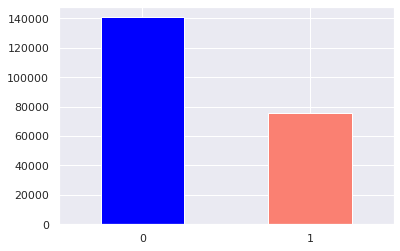

In [ ]:
# Let's plot a graph of our target classes
sns.set()
df.legitimate.value_counts().plot(kind='bar', color=['blue', 'salmon'])
plt.xticks(rotation=0);

From the graph, we can see that our dataset is imbalanced, we will oversample the 1-class 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216352 entries, 0 to 216351
Data columns (total 58 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           216352 non-null  int64  
 1   md5                          216352 non-null  object 
 2   Machine                      216352 non-null  object 
 3   SizeOfOptionalHeader         216352 non-null  int64  
 4   Characteristics              216352 non-null  int64  
 5   MajorLinkerVersion           216351 non-null  float64
 6   MinorLinkerVersion           216352 non-null  int64  
 7   SizeOfCode                   216352 non-null  int64  
 8   SizeOfInitializedData        216352 non-null  int64  
 9   SizeOfUninitializedData      216352 non-null  int64  
 10  AddressOfEntryPoint          216352 non-null  int64  
 11  BaseOfCode                   216352 non-null  int64  
 12  BaseOfData                   216352 non-null  int64  
 13 

In [ ]:
# let's look at our machine column
df.Machine

0         332
1         332
2         332
3         332
4         332
         ... 
216347    332
216348    332
216349    332
216350    332
216351    332
Name: Machine, Length: 216352, dtype: object

Looking at our machine column, its obvious that it wouldn't have effect on the target column, secondly, it is of dtype object (int), we will have difficulties trying to convert it to tensors for our neural network algorithm. So its best we drop the column. We will also drop our "unnamed: 57" column, since it is just filled up with NaN

In [ ]:
df = df.drop(['Machine', 'Unnamed: 57'], axis=1)

In [ ]:
df.isna().sum()

ID                             0
md5                            0
SizeOfOptionalHeader           0
Characteristics                0
MajorLinkerVersion             1
MinorLinkerVersion             0
SizeOfCode                     0
SizeOfInitializedData          0
SizeOfUninitializedData        0
AddressOfEntryPoint            0
BaseOfCode                     0
BaseOfData                     0
ImageBase                      0
SectionAlignment               0
FileAlignment                  0
MajorOperatingSystemVersion    0
MinorOperatingSystemVersion    0
MajorImageVersion              0
MinorImageVersion              0
MajorSubsystemVersion          0
MinorSubsystemVersion          0
SizeOfImage                    0
SizeOfHeaders                  0
CheckSum                       0
Subsystem                      0
DllCharacteristics             0
SizeOfStackReserve             0
SizeOfStackCommit              0
SizeOfHeapReserve              0
SizeOfHeapCommit               0
LoaderFlag

So we have just one missing field, we will drop the field

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

ID                             0
md5                            0
SizeOfOptionalHeader           0
Characteristics                0
MajorLinkerVersion             0
MinorLinkerVersion             0
SizeOfCode                     0
SizeOfInitializedData          0
SizeOfUninitializedData        0
AddressOfEntryPoint            0
BaseOfCode                     0
BaseOfData                     0
ImageBase                      0
SectionAlignment               0
FileAlignment                  0
MajorOperatingSystemVersion    0
MinorOperatingSystemVersion    0
MajorImageVersion              0
MinorImageVersion              0
MajorSubsystemVersion          0
MinorSubsystemVersion          0
SizeOfImage                    0
SizeOfHeaders                  0
CheckSum                       0
Subsystem                      0
DllCharacteristics             0
SizeOfStackReserve             0
SizeOfStackCommit              0
SizeOfHeapReserve              0
SizeOfHeapCommit               0
LoaderFlag

In [ ]:
# Let's look at our characteristics column
df.Characteristics

0          8450
1           258
2          8450
3          8450
4          8226
          ...  
216347      258
216348    33167
216349      258
216350    33166
216351      258
Name: Characteristics, Length: 216351, dtype: int64

In [ ]:
pd.crosstab(df.legitimate, df.Characteristics)

Characteristics,0,2,3,6,7,14,15,34,35,39,46,47,115,224,258,259,262,263,266,267,270,271,286,287,290,291,294,295,302,303,322,354,370,386,387,399,502,515,519,526,...,8750,8962,8966,8970,8974,9006,9486,10498,10530,11298,11522,11534,17679,18811,24846,33154,33158,33162,33166,33167,33170,33183,33198,33199,33678,33679,33695,34178,34182,35083,36751,36767,36831,36866,41358,41362,41870,41871,49086,49551
legitimate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,9,4,11,6,6,20,924,52,8,32,47,1,1,78087,9994,24,126,25,70,1519,23134,7,43,400,606,3,5,42,30,1,2,3,327,2,2,1,4,4,3,...,0,27,28,10,94,0,0,4,2,0,8,2,4,5,0,3,1,11,3103,7911,1,2,1,2,84,284,4,2,1,1,1,2,1,1,207,5,13,2,1,1
1,0,25,0,0,0,0,0,3136,257,0,0,3,0,0,5679,611,0,7,2,0,459,1672,2,31,450,28,11,1,72,23,0,0,0,0,0,0,0,0,1,0,...,1,16,44,14,74,5,3,2,6,293,601,69,0,0,63,0,0,0,26,65,0,0,1,0,1,2,0,0,0,0,0,0,0,0,10,0,0,0,0,0


### Data Preprocessing Lyer

In [ ]:
# Firstly, lets oversample our imbalanced class
def sample_dataset(dataset):
  """
  takes a dataset and oversamples the minority class
  """
  count_class_0, count_class_1 = dataset.legitimate.value_counts()
  class_0 = dataset[dataset['legitimate']==0]
  class_1 = dataset[dataset['legitimate']==1]

  # Oversample the minority class
  class_1_over = class_1.sample(count_class_0, replace=True)
  dataset_over = pd.concat([class_0, class_1_over], axis=0)

  return dataset_over

In [ ]:
df = sample_dataset(df)

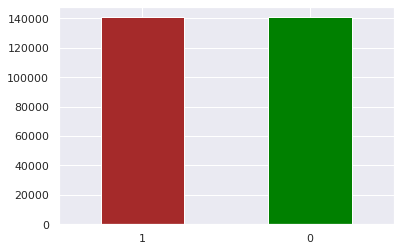

In [ ]:
df.legitimate.value_counts().plot(kind='bar', color=['brown', 'green'])
plt.xticks(rotation=0);

our dataset now has a balanced target class

In [ ]:
# Get the column type and store them in an array
numerical_features = []
categorical_features = []
for column in df.columns:
  if df[column].dtype == np.float64 or df[column].dtype == np.int64:
    numerical_features.append(column)
  else:
    categorical_features.append(column)

In [ ]:
categorical_features

['md5']

In [ ]:
# Preprocessing using feature columns
# numeric columns
feature_columns = [tf.feature_column.numeric_column(k) for k in numerical_features]

# Categorical Columns:
# For the categorical column, we will use the categorical_column_with_hash_bucket for 
# columns having a high amount of unique values, and categorical_column_with_vocabulary_list 
# if we have a reasonable amount of unique values.

for k in categorical_features:
  current_bucket = df[k].nunique()
  if current_bucket < 10:
    feature_columns.append(tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            key = k, vocabulary_list = df[k].unique()
        )
    ))
  else:
    feature_columns.append(tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_hash_bucket(key = k, hash_bucket_size=current_bucket))
    )

In [ ]:
feature_columns = tf.keras.layers.DenseFeatures(feature_columns)

In [ ]:
feature_columns

## Input Pipelines

In [ ]:
# A utility method to create a tf.data datset from pandas dataframe

def df_to_dataset(dataset, shuffle=True, batch_size = 32):
    """
    Takes in a pandas dataframe, converts it to tf.data dataset,
    shuffles, it, batchifies and prefetches it
    """
    np.random.seed(42)
    tf.random.set_seed(42)
    # copies the dataframe
    dataset = dataset.copy()
    labels = dataset['legitimate']
    # convert to tf.dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(dataset), labels))
    # Shuffle if train data
    if shuffle:
      dataset = dataset.shuffle(10000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)

    return dataset

In [ ]:
# let's split our dataset into train, valid and test
np.random.seed(42)
tf.random.set_seed(42)
train_valid, test = train_test_split(df, test_size=0.1)
train, valid = train_test_split(train_valid, test_size=0.2)

In [ ]:
train_set = df_to_dataset(train)
valid_set = df_to_dataset(valid, shuffle = False)
test_set = df_to_dataset(test, shuffle = False)

In [ ]:
# Let's take a view of our dataset
for feature_batch, label_batch in train_set.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of md5:', feature_batch['md5'])
  print('A batch of targets:', label_batch )

Every feature: ['ID', 'md5', 'SizeOfOptionalHeader', 'Characteristics', 'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage', 'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics', 'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve', 'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb', 'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize', 'SectionsMeanVirtualsize', 'SectionsMinVirtualsize', 'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb', 'ImportsNbOrdinal', 'ExportNb', 'ResourcesNb', 'ResourcesMeanEntropy', 'ResourcesMinEntropy', 'ResourcesMaxE

## Train, Evaluate and Save Model

In [ ]:
# Let's create a function that will build our model (we can easily tweak this function)
BATCH_SIZE = 32
def build_model(feature_columns, n_hidden = 2, n_neurons = 300):
  """
  """
  model = tf.keras.models.Sequential()
  model.add(feature_columns)
  for layer in range(n_hidden):
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(n_neurons, activation = 'relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer = tf.optimizers.SGD(lr=0.0001),
                metrics=['accuracy'])
  
  return model

In [ ]:
# Let's write a function to train our model
import datetime
import os
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('chris_model.h5')
log_dir = os.path.join('/content/drive/My Drive/Malware Detector/logs',
                       datetime.datetime.now().strftime('%y%m%d-%H%M%S'))
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

def train_model(train_data, valid_data, callbacks, feature_columns):
  """
  Takes in train_data, valid_data, callbacks, preprocessing_layer as
  args and trains our model
  """
  # create the model
  
  model = build_model(feature_columns)
  # Fit the model to the data passing it the callbacks we created
  model.fit(train_data, validation_data=valid_data,
            epochs=100, callbacks=callbacks)
  return model

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a  model in a given model directory and appends a suffix(string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("/content/drive/My Drive/Malware Detector/models",
                           datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5"  # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

  # Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specifid path.
  """
  print(f"Loading saved model from: {model_path}...")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={'KerasLayer': hub.KerasLayer})
  return model

In [ ]:
# Let's train our model
model = train_model(train_data = train_set, valid_data = valid_set, callbacks = callbacks, feature_columns = feature_columns)


Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

6339/6339 [==============================] - 120s 19ms/step - loss: 0.0508 - accuracy: 0.9917 - val_loss: 0.5166 - val_accuracy: 0.9935
Epoch 2/100
6339/6339 [==============================] - 119s 19ms/step - loss: 0.0098 - accuracy: 0.9996 - val_loss: 0.4303 - val_accuracy: 0.9977
Epoch 3/100
6339/6339 [==============================] - 120s 19ms/step - loss: 0.0058 - accuracy: 0.9998 - val_loss: 0.0574 - val_accuracy: 0.9984
Epoch 4/100
6339/6339 [==============================] - 120s 19

In [ ]:
model.evaluate(valid_set)

1585/1585 [==============================] - 12s 8ms/step - loss: 0.1281 - accuracy: 0.9996


[0.12805557250976562, 0.9996252655982971]

So we've gotten about 100% accuracy, let's make predictinos on test data

In [ ]:
# Let's save the model
save_model(model, suffix='malware_detector')

Saving model to: /content/drive/My Drive/Malware Detector/models/20200708-150437-malware_detector.h5...


'/content/drive/My Drive/Malware Detector/models/20200708-150437-malware_detector.h5'

In [ ]:
# Let's make some predictions
predictions = model.predict(test_set)

In [ ]:
predictions

array([[2.4384554e-02],
       [2.1067866e-04],
       [1.4872978e-03],
       ...,
       [9.9193209e-01],
       [9.6464360e-01],
       [9.9816543e-01]], dtype=float32)

In [ ]:
predictions = model.predict(test_set)
# Show some results
for prediction, malware in zip(predictions[:10], list(test_set)[0][1][:10]):
  prediction = tf.sigmoid(prediction).numpy()
  print("Predicted malware: {:.2%}".format(prediction[0]),
        " | Actual outcome: ",
        ("MALWARE" if bool(malware) else "LEGITIMATE"))

Predicted malware: 50.61%  | Actual outcome:  LEGITIMATE
Predicted malware: 50.01%  | Actual outcome:  LEGITIMATE
Predicted malware: 50.04%  | Actual outcome:  LEGITIMATE
Predicted malware: 50.01%  | Actual outcome:  LEGITIMATE
Predicted malware: 72.85%  | Actual outcome:  MALWARE
Predicted malware: 50.01%  | Actual outcome:  LEGITIMATE
Predicted malware: 73.09%  | Actual outcome:  MALWARE
Predicted malware: 73.09%  | Actual outcome:  MALWARE
Predicted malware: 73.10%  | Actual outcome:  MALWARE
Predicted malware: 50.50%  | Actual outcome:  LEGITIMATE
